In [82]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

In [83]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## TO DOs
* ~~import CelebA .csv~~
* ~~compute percentage of men and women for any other categories~~
    * ~~visualisation~~
* ~~compute distribution of our ranking score for every category~~
    * ~~visualisation~~
* ~~print the top 36 images~~
* ~~import features space after TSNE~~
    * ~~print such a space with points colored with a heatmap according with the ranking score~~
* import the result of partial clustering 
    * print the centroid for every cluster

In [127]:
# paths 
celebA_csv = "../data/celeba/list_attr_celeba.csv"
female_csv = "../data/celeba/celebA_female.csv"
male_csv = "../data/celeba/celebA_male.csv"

results_folder = "../results"
models_folder = ('../results/Results_CelebA_facenet/'
                     'Results_CelebA_facenet/input_dim_512/'
                     'init_trunc_inv_sqrt/layers_5/neuron_512/'
                     'lambda_cvx_0.1_mean_0.0/'
                     'optim_Adamlr_0.001betas_0.5_0.99/gen_5/batch_300/'
                     'trial_1_last_inp_qudr')

In [129]:
# import celebA data
df = pd.read_csv(celebA_csv)
df_female = pd.read_csv(female_csv)
df_male = pd.read_csv(male_csv)

df_female.head()

,index,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values,values1,values_resnet18,values_facenet
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,6629.578613,-828.345459,5020.663086,108147832.0
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,6035.264160,-639.834961,1144.402954,110032888.0
2,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,1,-1,1,11405.099609,-720.791931,12310.530273,108639088.0
3,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,1,11328.725586,-594.776306,21725.021484,108381480.0
4,5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,1,3073.829590,-995.757385,299.627960,108359744.0


We compute the percentage of men and women for each attribute in CelebA.

In [130]:
# for every attribute, compute the percentage of men and women with that attribute
n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Female" : n_female_col/n_female,
                 "Male" : n_male_col/n_male}

bias.pop("image_id")
bias.pop("Male")

{'Female': 0.0, 'Male': 1.0}

In [131]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))
    plt.show()

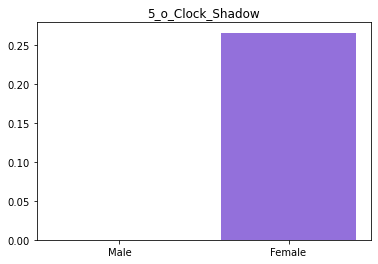

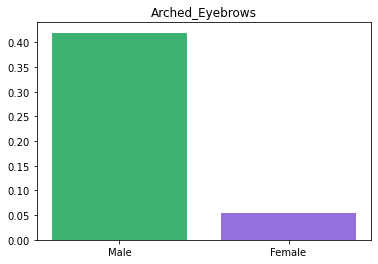

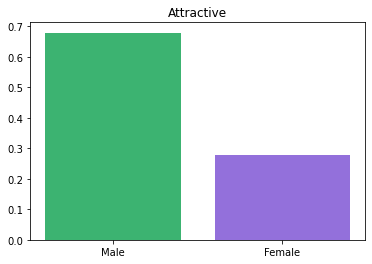

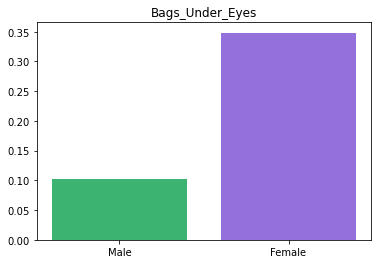

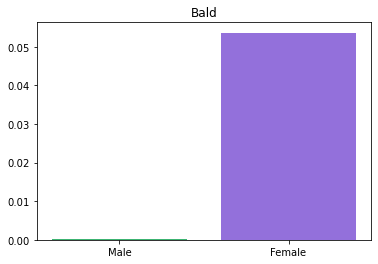

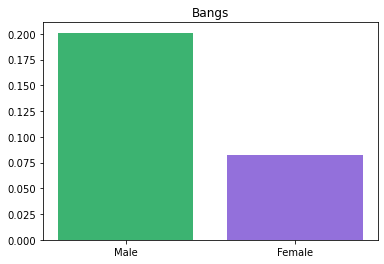

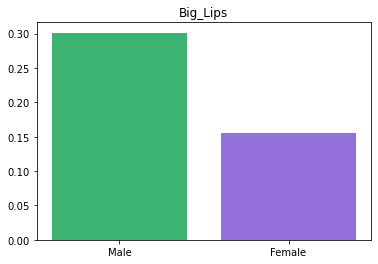

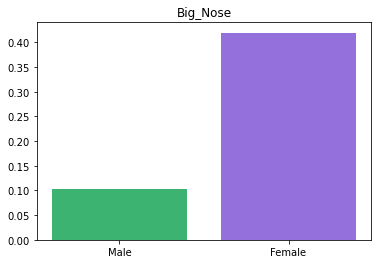

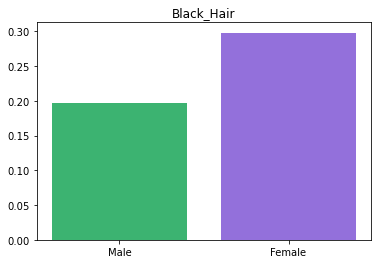

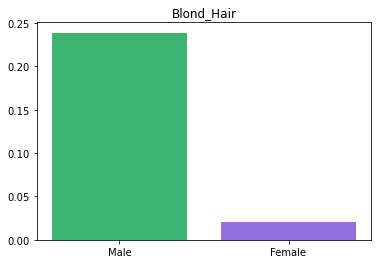

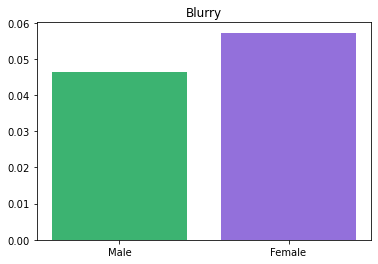

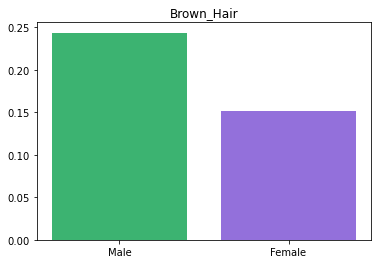

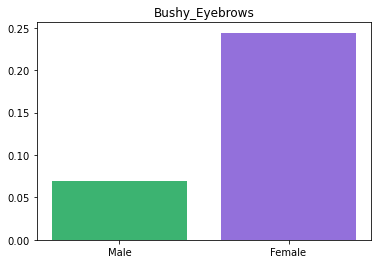

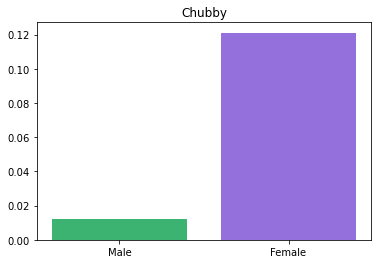

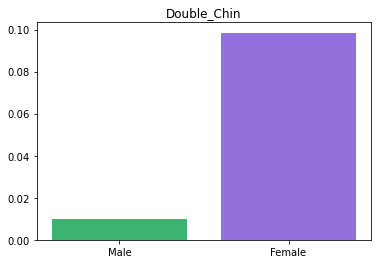

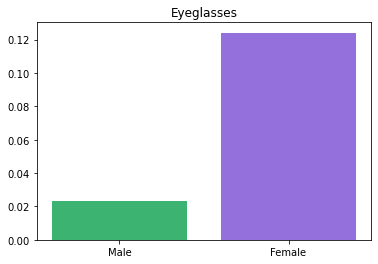

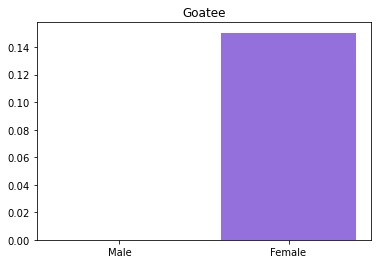

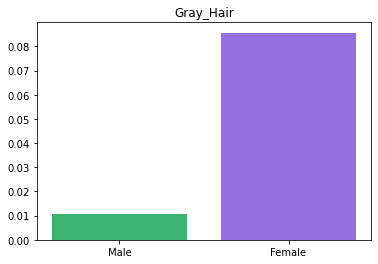

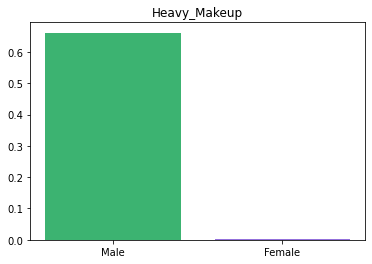

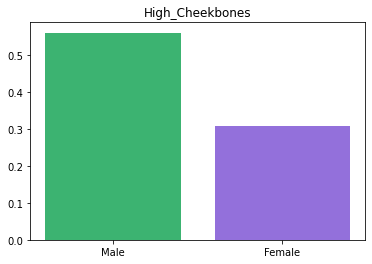

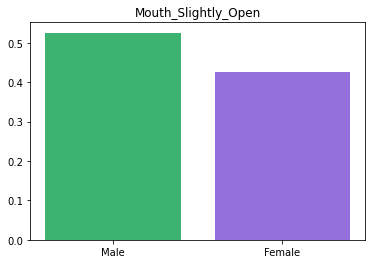

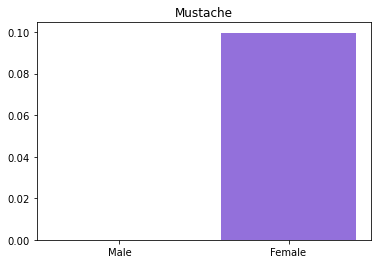

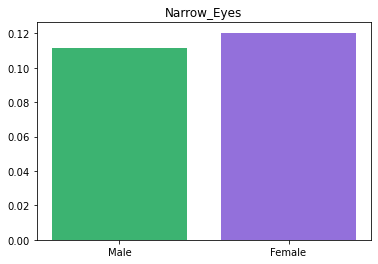

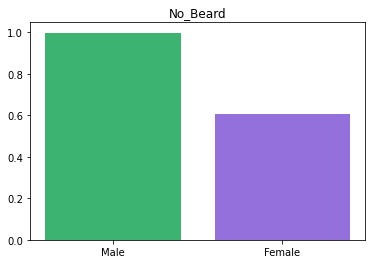

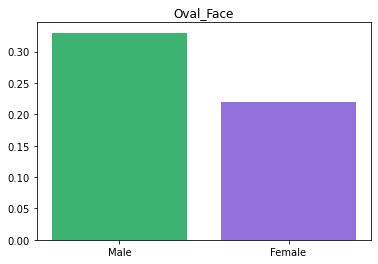

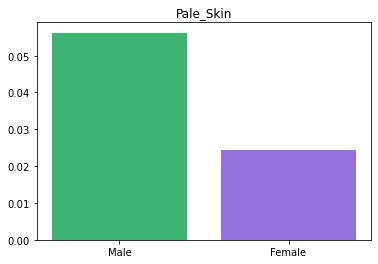

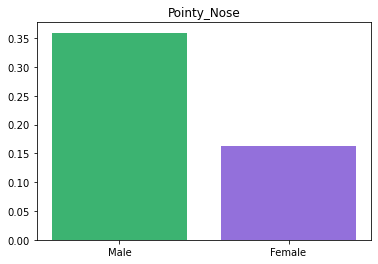

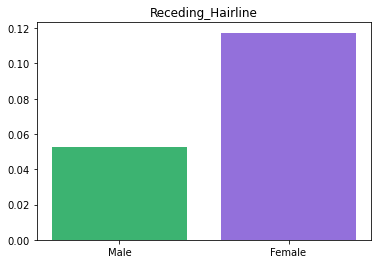

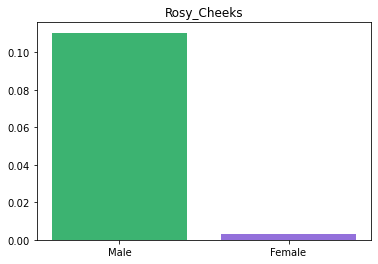

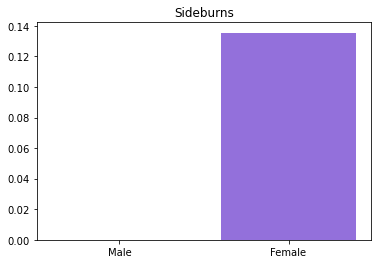

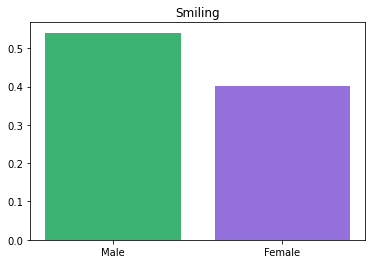

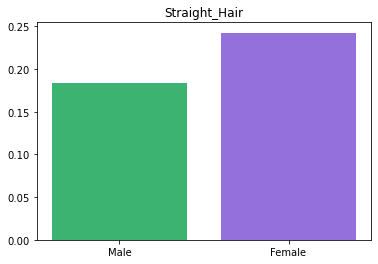

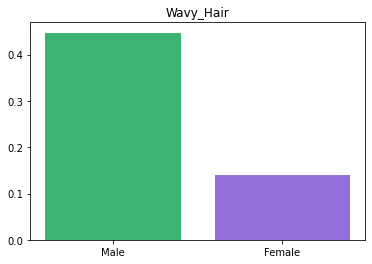

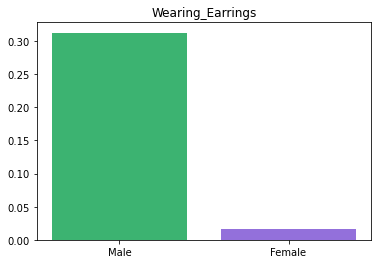

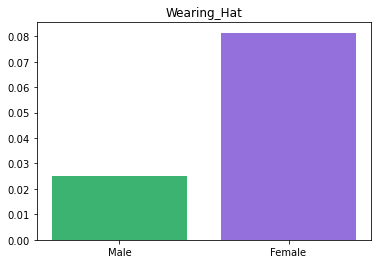

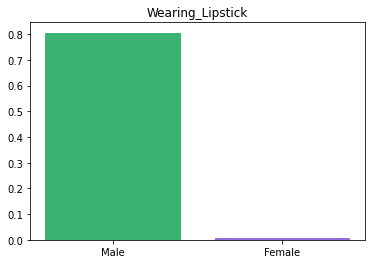

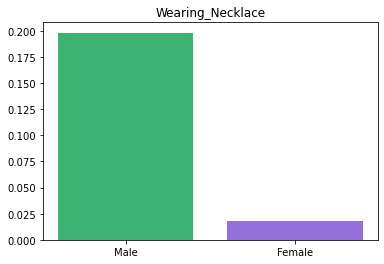

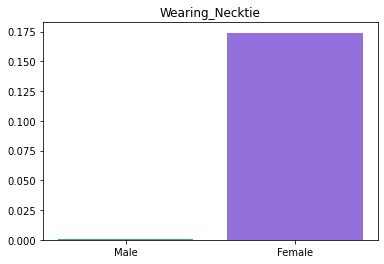

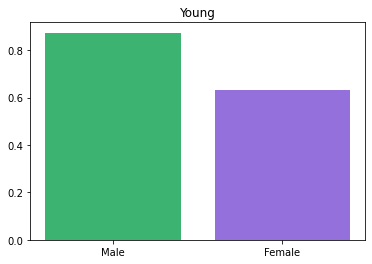

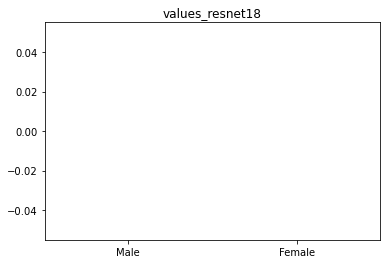

<Figure size 432x288 with 0 Axes>

In [132]:
# save the barplots
for col, values in bias.items():
    make_barplot(results_folder + "/barplots_celeba", col, values)
    plt.clf()

In [133]:
bias.items()

dict_items([('5_o_Clock_Shadow', {'Female': 0.0001692548554986671, 'Male': 0.26643295354951796}), ('Arched_Eyebrows', {'Female': 0.419557398552871, 'Male': 0.05345003197763934}), ('Attractive', {'Female': 0.6791689586595016, 'Male': 0.27925953999573633}), ('Bags_Under_Eyes', {'Female': 0.10190834849574747, 'Male': 0.3482483359783973}), ('Bald', {'Female': 0.00014386662717386705, 'Male': 0.053651372669777576}), ('Bangs', {'Female': 0.20106630558964161, 'Male': 0.08231281237416206}), ('Big_Lips', {'Female': 0.30132441924427705, 'Male': 0.15608641068763768}), ('Big_Nose', {'Female': 0.1022722464350696, 'Male': 0.4196295331264656}), ('Black_Hair', {'Female': 0.19731731054034612, 'Male': 0.2979368500840893}), ('Blond_Hair', {'Female': 0.23893707950746837, 'Male': 0.020714404149986973}), ('Blurry', {'Female': 0.046367367663859856, 'Male': 0.05723997441788853}), ('Brown_Hair', {'Female': 0.24359158803368172, 'Male': 0.1514555747684582}), ('Bushy_Eyebrows', {'Female': 0.06923369864172979, 'Mal

We compute the distribution of the ranking score for men and women with respect to each attribute.

In [134]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    plt.savefig(path + "/{}.jpeg".format(col))
    plt.show()

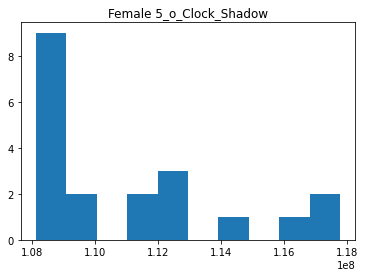

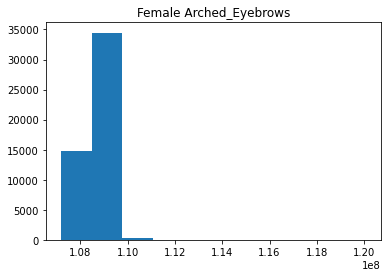

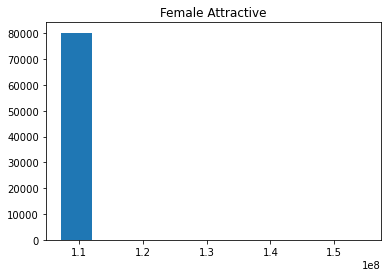

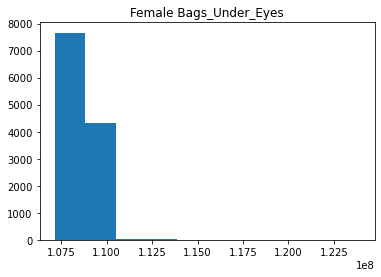

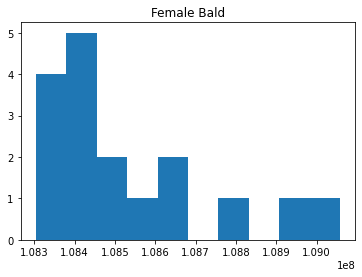

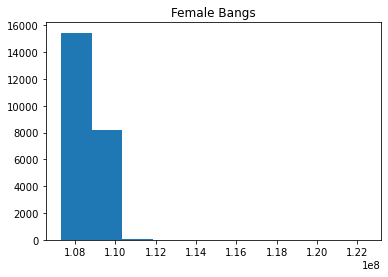

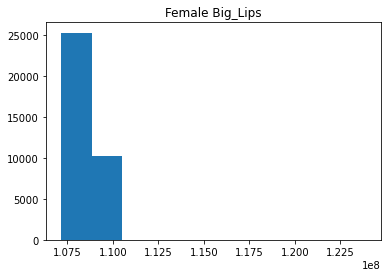

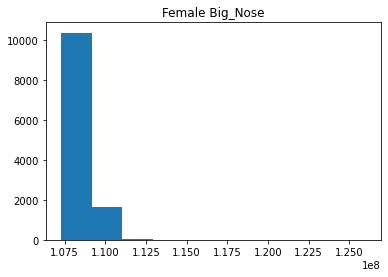

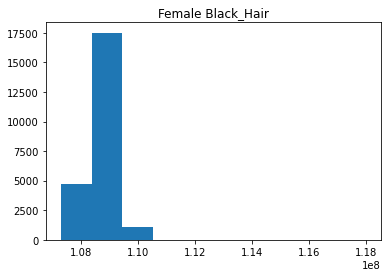

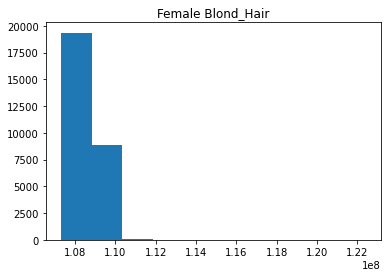

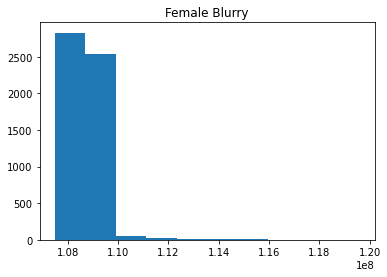

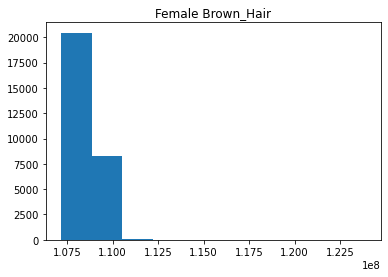

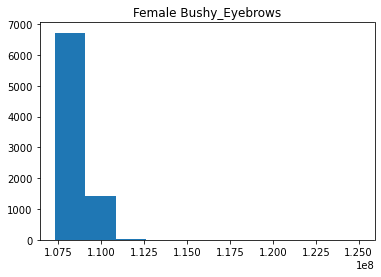

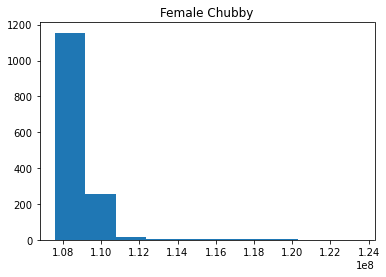

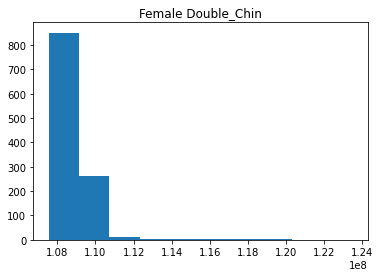

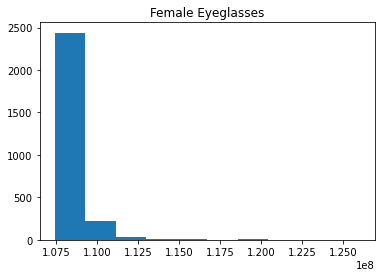

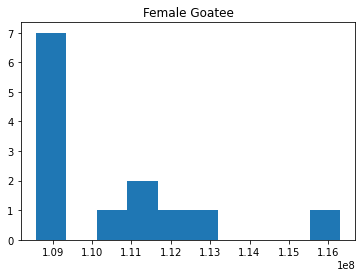

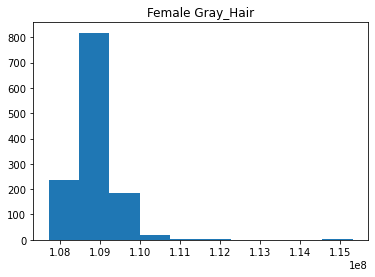

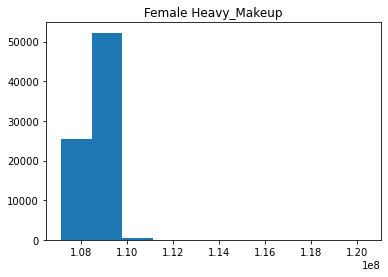

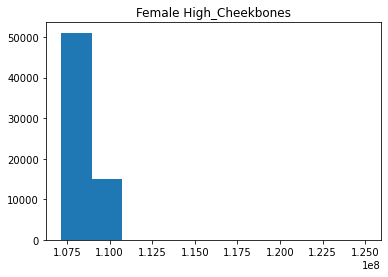

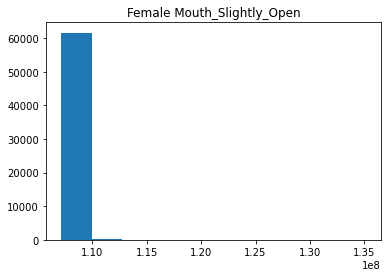

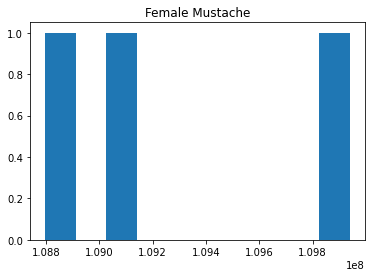

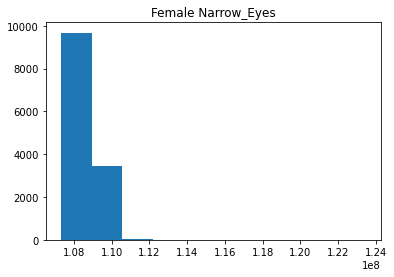

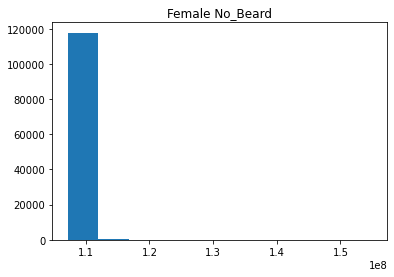

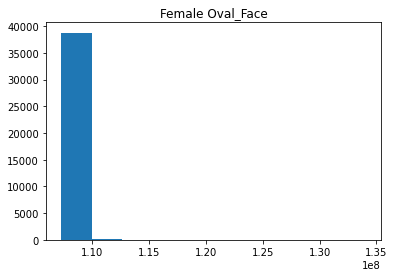

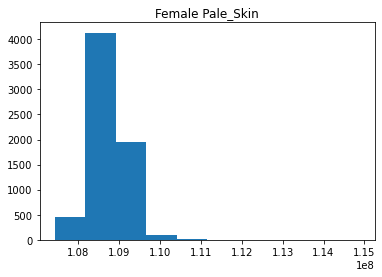

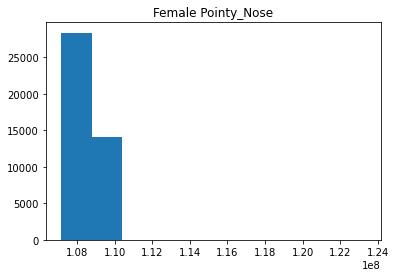

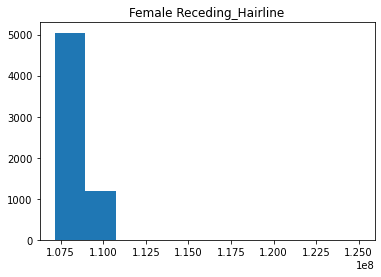

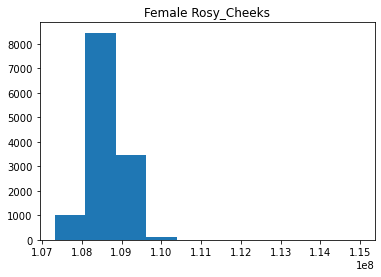

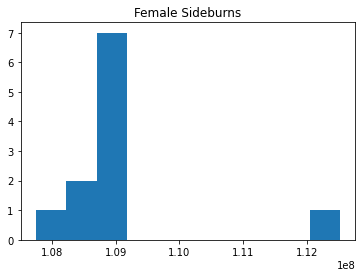

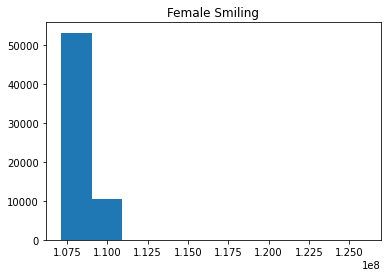

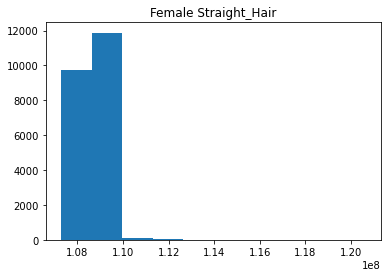

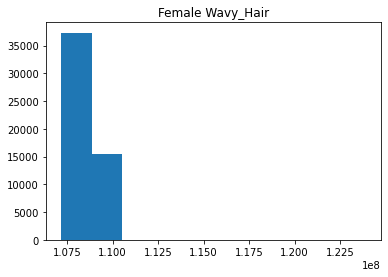

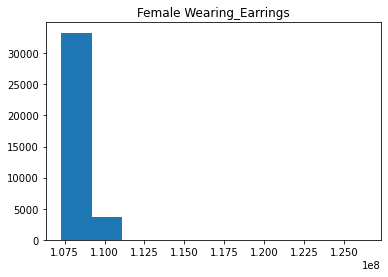

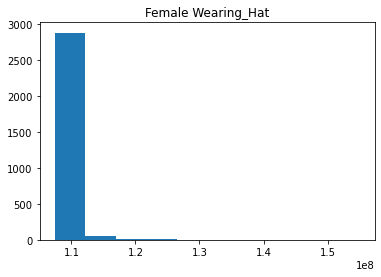

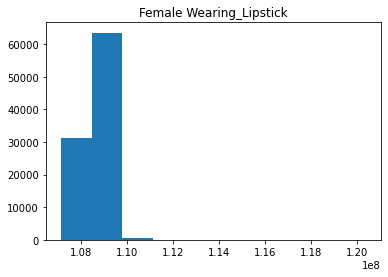

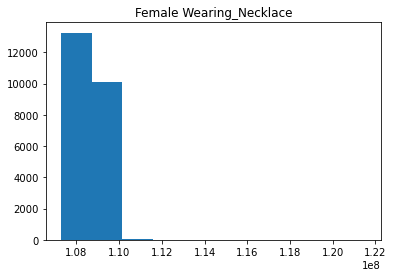

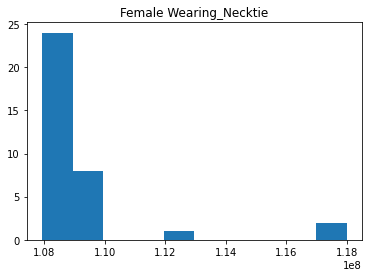

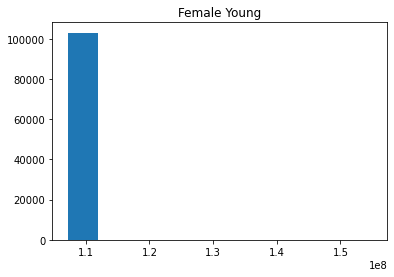

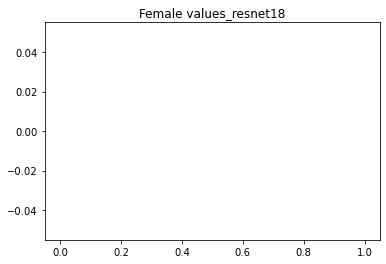

<Figure size 432x288 with 0 Axes>

In [135]:
df_gender = df[df["Male"] == -1]

gender = "Female"
for col in bias.keys():
    make_histograms(results_folder + "/histograms_celeba", df=df_female,
                    col=col, score="values_facenet", gender=gender)
    plt.clf()

In [136]:
bias.keys()

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'values_resnet18'])

We plot the top 36 images according to the ranking. 

In [137]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [138]:
img_ids = df_female.sort_values(by="values_facenet", ascending=True)["image_id"][:36]
array_img_vectors = np.array(
    [skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
     for file in img_ids])

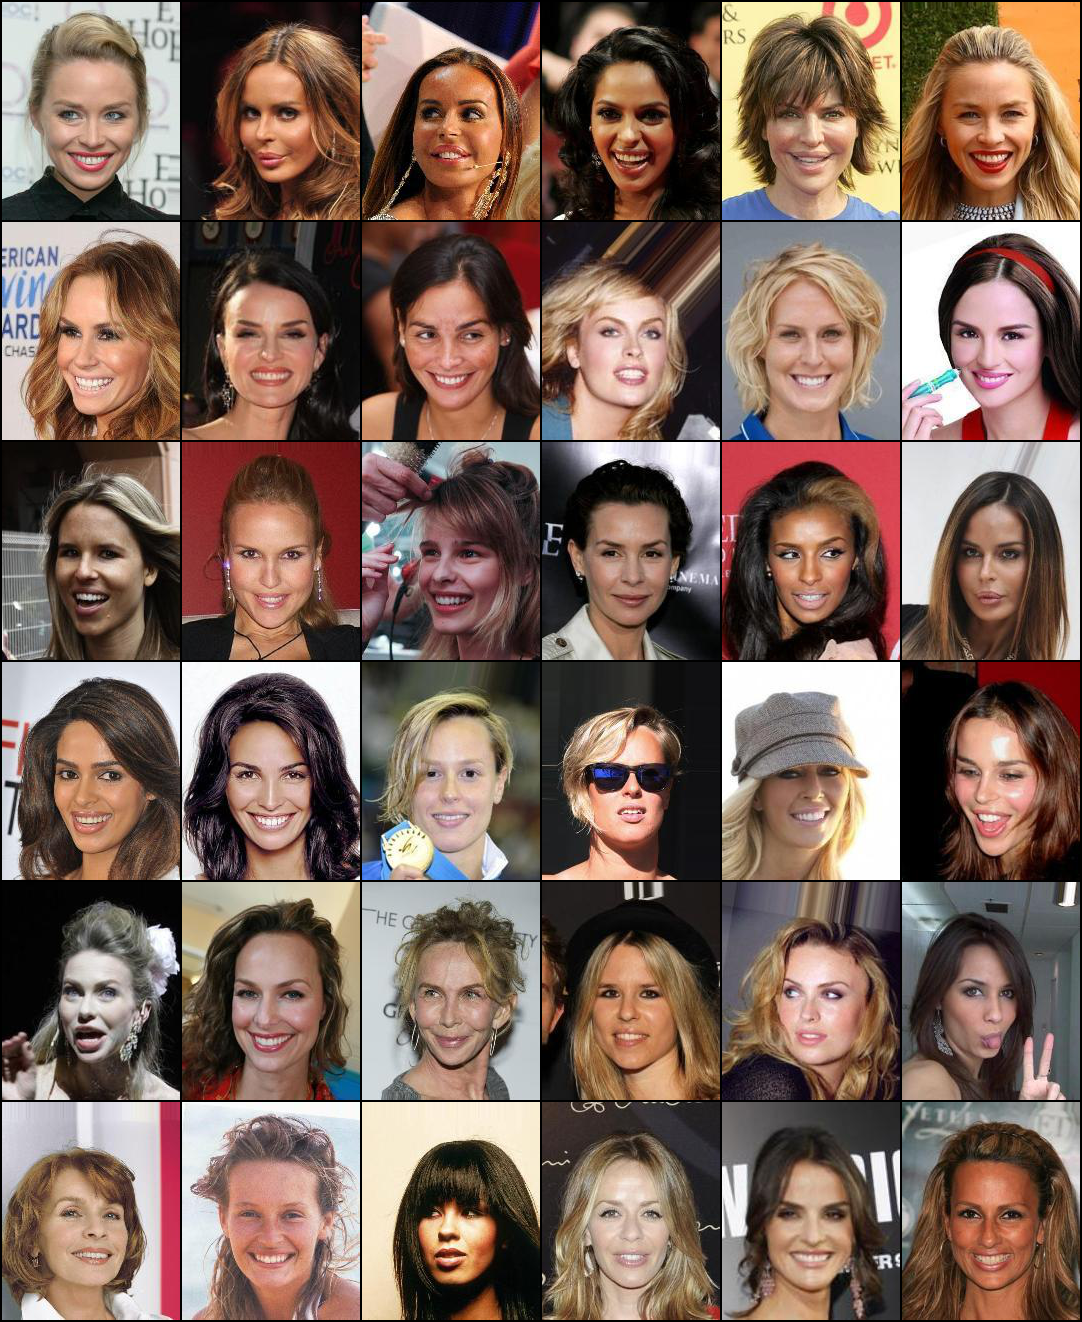

In [139]:
save_images_as_grid("", array_img_vectors)

We open the numpy array of our feature space

In [140]:
def open_array():
    pass

In [141]:
path_arr = '../data/facenet'

We plot the TSNE representation of our space. We distinguisce points sampled from the two distributions. The features extracted from female subjects are colered according to our ranking score.

In [142]:
def plot_tsne(path, array1, array2, scores):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray")
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r")
    plt.title("TSNE representation of the feature space")
    
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [143]:
sample = df.sample(10000)

X_data = src.datasets.CelebA_Features(celebA_csv, path_arr)
X_data_sample = torch.utils.data.Subset(X_data, sample.index)

X_loader = torch.utils.data.DataLoader(X_data, batch_size=1)

In [144]:
sample_space = list()
gender = list()
for batch, _, _, g in X_loader:
    sample_space.append(batch.detach().numpy())
    gender.append(g)
    
sample_space = np.concatenate(space)
gender = np.array(gender)

/tmp/ipykernel_835486/426442226.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gender = np.array(gender)
/tmp/ipykernel_835486/426442226.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gender = np.array(gender)


In [149]:
sample.reset_index(inplace=True)

sample_female = sample[sample["Male"] == -1].sample(500)
df_score = pd.merge(sample_female, df_female, on = "image_id")
sample_female_score = -df_score["values_facenet"].values
sample_female_array = sample_space[sample_female.index]


sample_male = sample[sample["Male"] == 1].sample(500)
sample_male_array = sample_space[sample_male.index]


#tsne = TSNE()
#transformed_space = tsne.fit_transform(sample_space)

In [150]:
df_score.columns

Index(['level_0', 'index_x', 'image_id', '5_o_Clock_Shadow_x',
       'Arched_Eyebrows_x', 'Attractive_x', 'Bags_Under_Eyes_x', 'Bald_x',
       'Bangs_x', 'Big_Lips_x', 'Big_Nose_x', 'Black_Hair_x', 'Blond_Hair_x',
       'Blurry_x', 'Brown_Hair_x', 'Bushy_Eyebrows_x', 'Chubby_x',
       'Double_Chin_x', 'Eyeglasses_x', 'Goatee_x', 'Gray_Hair_x',
       'Heavy_Makeup_x', 'High_Cheekbones_x', 'Male_x',
       'Mouth_Slightly_Open_x', 'Mustache_x', 'Narrow_Eyes_x', 'No_Beard_x',
       'Oval_Face_x', 'Pale_Skin_x', 'Pointy_Nose_x', 'Receding_Hairline_x',
       'Rosy_Cheeks_x', 'Sideburns_x', 'Smiling_x', 'Straight_Hair_x',
       'Wavy_Hair_x', 'Wearing_Earrings_x', 'Wearing_Hat_x',
       'Wearing_Lipstick_x', 'Wearing_Necklace_x', 'Wearing_Necktie_x',
       'Young_x', 'values_resnet18_x', 'index_y', '5_o_Clock_Shadow_y',
       'Arched_Eyebrows_y', 'Attractive_y', 'Bags_Under_Eyes_y', 'Bald_y',
       'Bangs_y', 'Big_Lips_y', 'Big_Nose_y', 'Black_Hair_y', 'Blond_Hair_y',
       'Blu

In [151]:
sample_female.columns

Index(['level_0', 'index', 'image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'values_resnet18'],
      dtype='object')

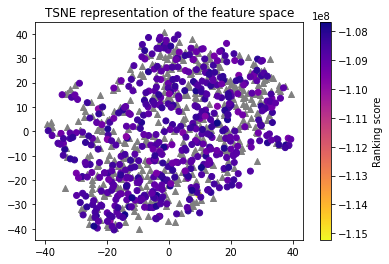

In [152]:
plot_tsne("",
          transformed_space[sample_male.index],
          transformed_space[sample_female.index],
          sample_female_score)

We cluster the features of the top 10% images according to the ranking and show the images that are the closest to the centroids. 

In [54]:
nintieth_quatile = df[df["Male"] == -1].values_resnet18.quantile(.9)

indices = df[(df["Male"] == -1) & (df["values_resnet18"] >= nintieth_quatile)].index

to_cluster = space[indices]

In [56]:
kmeans.cluster_centers_

array([[ 0.24542248,  1.3234451 ,  0.75425637, ..., -3.6656566 ,
         1.4433006 ,  3.4836373 ],
       [ 1.5903077 ,  0.7432894 ,  1.4207814 , ..., -3.3898478 ,
         1.194732  ,  2.8993895 ],
       [ 0.39759052,  0.8665465 ,  0.923121  , ..., -3.6218328 ,
         0.52789676,  2.7219548 ],
       ...,
       [ 2.9594417 ,  1.5846395 ,  2.2480414 , ..., -1.9001051 ,
         1.5228467 ,  3.2557566 ],
       [ 0.1037339 ,  0.51063377,  0.822659  , ..., -3.8597035 ,
         1.4199406 ,  2.4671056 ],
       [ 0.62433237,  1.1406858 ,  1.6074343 , ..., -3.6017938 ,
         1.9873252 ,  3.2752433 ]], dtype=float32)

In [62]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit(to_cluster)

KMeans(n_clusters=5)

Centroid of cluster 0


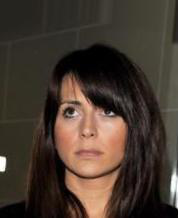

Centroid of cluster 1


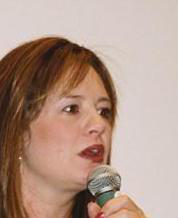

Centroid of cluster 2


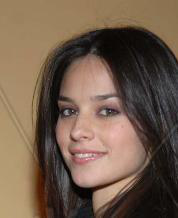

Centroid of cluster 3


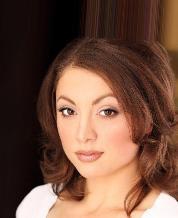

Centroid of cluster 4


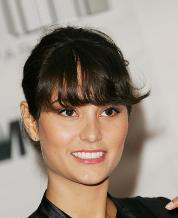

In [63]:
for i in set(kmeans.labels_):
    # select elements of the cluster
    elements = to_cluster[kmeans.labels_ == i]
    
    centroid = kmeans.cluster_centers_[i]
 
    minimum = elements[np.linalg.norm(elements - centroid, axis = 1).argmin()]

    to_print = np.linalg.norm(space - minimum, axis = 1).argmin()
    
    file = df.loc[to_print, "image_id"]
    image = skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
    
    im = Image.fromarray(image)

    #im.save(path)
    print("Centroid of cluster {}".format(i))
    display(im)
    